In [1]:
import sys
import penaltyblog as pb
sys.path.append("../../")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance

df = pd.read_csv("https://www.football-data.co.uk/mmz4281/2223/E0.csv")
df = df[["Date", "HomeTeam", "AwayTeam", "FTHG", "FTAG"]]
df.head()

WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


,Date,HomeTeam,AwayTeam,FTHG,FTAG
0,05/08/2022,Crystal Palace,Arsenal,0,2
1,06/08/2022,Fulham,Liverpool,2,2
2,06/08/2022,Bournemouth,Aston Villa,2,0
3,06/08/2022,Leeds,Wolves,2,1
4,06/08/2022,Newcastle,Nott'm Forest,2,0


# Custom functions

In [2]:
def simulate_season(sim, model):
    for index, row in sim.iterrows():
        home_team = row['HomeTeam']
        away_team = row['AwayTeam']
        
        probs = model.predict(home_team, away_team)
        home_goal_expectation = probs.home_goal_expectation
        away_goal_expectation = probs.away_goal_expectation
        
        home_goals = np.random.poisson(home_goal_expectation)
        away_goals = np.random.poisson(away_goal_expectation)
        
        sim.at[index, 'HG'] = home_goals
        sim.at[index, 'AG'] = away_goals

    sim['HG'] = sim['HG'].astype(int)
    sim['AG'] = sim['AG'].astype(int)

    return sim

def calculate_standings(sim):
    team_stats = {}

    for index, row in sim.iterrows():
        home_team = row['HomeTeam']
        away_team = row['AwayTeam']
        home_goals = row['HG']
        away_goals = row['AG']
        
        # Update or initialize stats for home team
        if home_team in team_stats:
            team_stats[home_team]['GF'] += home_goals
            team_stats[home_team]['GA'] += away_goals
            team_stats[home_team]['GD'] += (home_goals - away_goals)
            team_stats[home_team]['PTS'] += (3 if home_goals > away_goals else (1 if home_goals == away_goals else 0))
            team_stats[home_team]['P'] += 1
        
            if home_goals > away_goals:
                team_stats[home_team]['W'] += 1
            elif home_goals == away_goals:
                team_stats[home_team]['D'] += 1
            else:
                team_stats[home_team]['L'] += 1
        else:
            team_stats[home_team] = {'GF': home_goals, 'GA': away_goals, 'GD': (home_goals - away_goals),
                                    'PTS': (3 if home_goals > away_goals else (1 if home_goals == away_goals else 0)),
                                    'P': 1, 'W': 1 if home_goals > away_goals else 0,
                                    'D': 1 if home_goals == away_goals else 0, 'L': 1 if home_goals < away_goals else 0}

        # Update or initialize stats for away team
        if away_team in team_stats:
            team_stats[away_team]['GF'] += away_goals
            team_stats[away_team]['GA'] += home_goals
            team_stats[away_team]['GD'] += (away_goals - home_goals)
            team_stats[away_team]['PTS'] += (3 if away_goals > home_goals else (1 if away_goals == home_goals else 0))
            team_stats[away_team]['P'] += 1
            
            if away_goals > home_goals:
                team_stats[away_team]['W'] += 1
            elif away_goals == home_goals:
                team_stats[away_team]['D'] += 1
            else:
                team_stats[away_team]['L'] += 1
        else:
            team_stats[away_team] = {'GF': away_goals, 'GA': home_goals, 'GD': (away_goals - home_goals),
                                    'PTS': (3 if away_goals > home_goals else (1 if away_goals == home_goals else 0)),
                                    'P': 1, 'W': 1 if away_goals > home_goals else 0,
                                    'D': 1 if away_goals == home_goals else 0, 'L': 1 if away_goals < home_goals else 0}

    standings = pd.DataFrame.from_dict(team_stats, orient='index')
    standings.index.name = 'Team'

    # Calculate additional stats like Goal Difference, Wins, Draws, Losses, and Points Percentage
    standings['GD'] = standings['GF'] - standings['GA']
    standings['%'] = round((standings['PTS'] / (standings['P'] * 3)) * 100, 1)

    # Sort the standings by Points, Goal Difference, and Goals For
    standings = standings.sort_values(by=['PTS', 'GD', 'GF'], ascending=False)

    # Add Position (Pos) column
    standings.reset_index(inplace=True)
    standings['Pos'] = standings.index + 1
    standings.set_index('Pos', inplace=True)
    standings.index.name = 'Pos'
    standings = standings[['Team', 'PTS', 'P', 'W', 'D', 'L', 'GF', 'GA', 'GD', '%']]
    standings.reset_index(inplace=True)

    return standings

def euclidean_distance(df1, df2):
    if df1.shape != df2.shape:
        raise ValueError("Dataframes must have the same shape")

    # Calculate squared differences element-wise
    squared_diff = (df1 - df2) ** 2

    # Calculate RMSE (square root of mean of squared differences)
    rmse = np.sqrt(np.mean(squared_diff.values))
    return rmse

# Dixon Coles

In [3]:
dc = pb.models.DixonColesGoalModel(
    df["FTHG"], df["FTAG"], df["HomeTeam"], df["AwayTeam"]
)

dc.fit()

dc

Module: Penaltyblog

Model: Dixon and Coles

Number of parameters: 42
Log Likelihood: -1098.77
AIC: 2281.54

Team                 Attack               Defence             
------------------------------------------------------------
Arsenal              1.529                -1.049              
Aston Villa          0.985                -1.018              
Bournemouth          0.688                -0.595              
Brentford            1.11                 -1.018              
Brighton             1.335                -0.858              
Chelsea              0.688                -1.014              
Crystal Palace       0.741                -0.973              
Everton              0.583                -0.819              
Fulham               1.068                -0.874              
Leeds                0.951                -0.497              
Leicester            1.01                 -0.63               
Liverpool            1.369                -0.977              
Man City   

## Simulating a match

In [4]:
num_simulations = 1000
home_team = "Arsenal"
away_team = "Leicester"

probs = dc.predict(home_team, away_team)
home_goal_expectation = probs.home_goal_expectation
away_goal_expectation = probs.away_goal_expectation

print(home_team, "xG -", home_goal_expectation)
print(away_team, "xG -", away_goal_expectation)

poisson_home_goals = np.random.poisson(home_goal_expectation)
poisson_away_goals = np.random.poisson(away_goal_expectation)

print("\nMATCH SIMULATION")
print(home_team, "-", poisson_home_goals)
print(away_team, "-", poisson_away_goals)

Arsenal xG - 3.2872064539625856
Leicester xG - 0.9615575006542334

MATCH SIMULATION
Arsenal - 4
Leicester - 1


## Simulating a match 1000 times

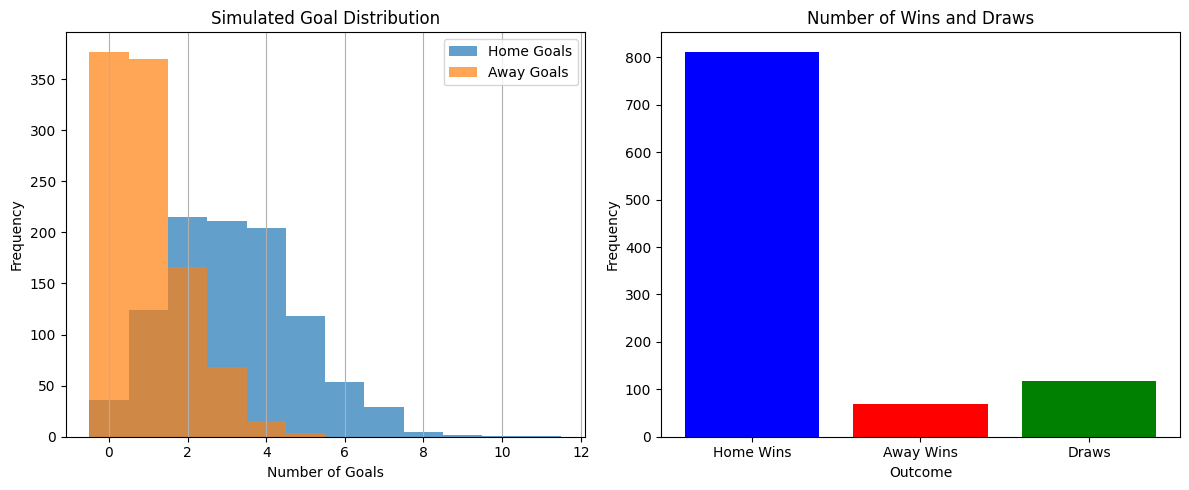

In [5]:
home_goals_simulated = np.random.poisson(home_goal_expectation, num_simulations)
away_goals_simulated = np.random.poisson(away_goal_expectation, num_simulations)

home_wins = np.sum(home_goals_simulated > away_goals_simulated)
away_wins = np.sum(home_goals_simulated < away_goals_simulated)
draws = np.sum(home_goals_simulated == away_goals_simulated)

# Plotting the distributions
plt.figure(figsize=(12, 5))

# Plotting goal distributions
plt.subplot(1, 2, 1)
plt.hist(home_goals_simulated, bins=np.arange(-0.5, max(home_goals_simulated) + 1.5, 1), alpha=0.7, label='Home Goals')
plt.hist(away_goals_simulated, bins=np.arange(-0.5, max(away_goals_simulated) + 1.5, 1), alpha=0.7, label='Away Goals')
plt.xlabel('Number of Goals')
plt.ylabel('Frequency')
plt.title('Simulated Goal Distribution')
plt.legend()
plt.grid(True, axis='x')

# Plotting win counts
plt.subplot(1, 2, 2)
labels = ['Home Wins', 'Away Wins', 'Draws']
values = [home_wins, away_wins, draws]
plt.bar(labels, values, color=['blue', 'red', 'green'])
plt.xlabel('Outcome')
plt.ylabel('Frequency')
plt.title('Number of Wins and Draws')

plt.tight_layout()
plt.show()

## Simulating the championship

In [6]:
sim = df[['HomeTeam', 'AwayTeam']].copy()
sim.head()

,HomeTeam,AwayTeam
0,Crystal Palace,Arsenal
1,Fulham,Liverpool
2,Bournemouth,Aston Villa
3,Leeds,Wolves
4,Newcastle,Nott'm Forest


In [7]:
sim_matches_dc = simulate_season(sim, dc)
sim_standings_dc = calculate_standings(sim_matches_dc)
sim_standings_dc

,Pos,Team,PTS,P,W,D,L,GF,GA,GD,%
0,1,Man City,89,38,27,8,3,100,35,65,78.1
1,2,Newcastle,81,38,24,9,5,72,29,43,71.1
2,3,Brighton,75,38,22,9,7,79,44,35,65.8
3,4,Arsenal,67,38,19,10,9,68,43,25,58.8
4,5,Brentford,63,38,16,15,7,64,47,17,55.3
5,6,Liverpool,62,38,17,11,10,63,50,13,54.4
6,7,Fulham,62,38,18,8,12,67,61,6,54.4
7,8,Aston Villa,61,38,17,10,11,60,45,15,53.5
8,9,Man United,59,38,17,8,13,74,54,20,51.8
9,10,Chelsea,53,38,12,17,9,45,44,1,46.5


## Simulating the championship 1000 times

In [8]:
all_standings_dc = []
num_simulations = 100

for i in range(num_simulations):
    matches = simulate_season(sim, dc)
    standings = calculate_standings(matches)
    all_standings_dc.append(standings)

# Now calculate the average standings
average_standings_dc = pd.concat(all_standings_dc).groupby('Team').mean().reset_index()

# Sort the average standings by Points, Goal Difference, and Goals For
average_standings_dc = average_standings_dc.sort_values(by=['PTS', 'GD', 'GF'], ascending=False)

# Add Position (Pos) column
average_standings_dc['Pos'] = average_standings_dc.index + 1
average_standings_dc.set_index('Pos', inplace=True)
average_standings_dc.index.name = 'Pos'
average_standings_dc = average_standings_dc[['Team', 'PTS', 'P', 'W', 'D', 'L', 'GF', 'GA', 'GD', '%']]
average_standings_dc.reset_index(drop=True, inplace=True)

# Display the average standings
average_standings_dc

,Team,PTS,P,W,D,L,GF,GA,GD,%
0,Man City,86.39,38.0,26.70,6.29,5.01,92.51,32.27,60.24,75.784
1,Arsenal,78.18,38.0,23.69,7.11,7.20,88.43,43.09,45.34,68.584
2,Newcastle,75.62,38.0,22.48,8.18,7.34,68.26,32.15,36.11,66.337
3,Liverpool,68.33,38.0,20.17,7.82,10.01,73.27,47.74,25.53,59.936
4,Brighton,63.84,38.0,18.65,7.89,11.46,71.73,54.17,17.56,56.002
5,Man United,62.58,38.0,17.84,9.06,11.10,57.63,41.98,15.65,54.895
6,Brentford,60.09,38.0,16.99,9.12,11.89,57.26,46.36,10.90,52.714
7,Tottenham,58.71,38.0,17.05,7.56,13.39,70.44,62.82,7.62,51.504
8,Aston Villa,55.93,38.0,15.60,9.13,13.27,50.80,45.97,4.83,49.060
9,Fulham,55.79,38.0,15.67,8.78,13.55,57.03,52.38,4.65,48.941


## Real standings

In [9]:
real = df.copy()
real.drop(columns=['Date'], inplace=True)
real.rename(columns={'FTHG': 'HG', 'FTAG': 'AG'}, inplace=True)

real_standings = calculate_standings(real)
real_standings

,Pos,Team,PTS,P,W,D,L,GF,GA,GD,%
0,1,Man City,89,38,28,5,5,94,33,61,78.1
1,2,Arsenal,84,38,26,6,6,88,43,45,73.7
2,3,Man United,75,38,23,6,9,58,43,15,65.8
3,4,Newcastle,71,38,19,14,5,68,33,35,62.3
4,5,Liverpool,67,38,19,10,9,75,47,28,58.8
5,6,Brighton,62,38,18,8,12,72,53,19,54.4
6,7,Aston Villa,61,38,18,7,13,51,46,5,53.5
7,8,Tottenham,60,38,18,6,14,70,63,7,52.6
8,9,Brentford,59,38,15,14,9,58,46,12,51.8
9,10,Fulham,52,38,15,7,16,55,53,2,45.6


## Comparing Real and Sim standings

In [11]:
# Merge real_standings and sim_standings on 'Team' to compare attributes
comparison = pd.merge(real_standings, average_standings_dc, on='Team', suffixes=('_real', '_sim'))

# Calculate absolute differences for each attribute
attributes = ['PTS', 'W', 'D', 'L', 'GF', 'GA', 'GD', '%']
for attr in attributes:
    comparison[f'{attr}_diff'] = abs(comparison[f'{attr}_sim'] - comparison[f'{attr}_real'])

# Reorder columns for better readability (if needed)
comparison = comparison[['Team'] + [f'{attr}_real' for attr in attributes] + [f'{attr}_sim' for attr in attributes] + [f'{attr}_diff' for attr in attributes]]

diff_columns = [col for col in comparison.columns if col.endswith('_diff')]
diff_columns.append('Team')
comparison = comparison[diff_columns]
columns_order = ['Team'] + [col for col in comparison.columns if col != 'Team']
comparison = comparison[columns_order]
comparison.columns = comparison.columns.str.replace('_diff', '')

comparison_dc = comparison
comparison_dc

,Team,PTS,W,D,L,GF,GA,GD,%
0,Man City,2.61,1.30,1.29,0.01,1.49,0.73,0.76,2.316
1,Arsenal,5.82,2.31,1.11,1.20,0.43,0.09,0.34,5.116
2,Man United,12.42,5.16,3.06,2.10,0.37,1.02,0.65,10.905
3,Newcastle,4.62,3.48,5.82,2.34,0.26,0.85,1.11,4.037
4,Liverpool,1.33,1.17,2.18,1.01,1.73,0.74,2.47,1.136
5,Brighton,1.84,0.65,0.11,0.54,0.27,1.17,1.44,1.602
6,Aston Villa,5.07,2.40,2.13,0.27,0.20,0.03,0.17,4.440
7,Tottenham,1.29,0.95,1.56,0.61,0.44,0.18,0.62,1.096
8,Brentford,1.09,1.99,4.88,2.89,0.74,0.36,1.10,0.914
9,Fulham,3.79,0.67,1.78,2.45,2.03,0.62,2.65,3.341


# Rue Salvesen

In [12]:
rs = pb.models.RueSalvesenGoalModel(
    df["FTHG"], df["FTAG"], df["HomeTeam"], df["AwayTeam"]
)

rs.fit()

rs

Module: Penaltyblog

Model: Rue Salvesen

Number of parameters: 43
Log Likelihood: -1086.68
AIC: 2259.361

Team                 Attack               Defence             
------------------------------------------------------------
Arsenal              1.591                -1.09               
Aston Villa          0.974                -0.986              
Bournemouth          0.683                -0.631              
Brentford            1.117                -1.004              
Brighton             1.381                -0.897              
Chelsea              0.637                -0.941              
Crystal Palace       0.702                -0.914              
Everton              0.544                -0.758              
Fulham               1.09                 -0.875              
Leeds                1.007                -0.546              
Leicester            1.055                -0.67               
Liverpool            1.305                -0.997              
Man City     

## Simulating a match

In [13]:
num_simulations = 1000
home_team = "Arsenal"
away_team = "Leicester"

probs = rs.predict(home_team, away_team)
home_goal_expectation = probs.home_goal_expectation
away_goal_expectation = probs.away_goal_expectation

print(home_team, "xG -", home_goal_expectation)
print(away_team, "xG -", away_goal_expectation)

poisson_home_goals = np.random.poisson(home_goal_expectation)
poisson_away_goals = np.random.poisson(away_goal_expectation)

print("\nMATCH SIMULATION")
print(home_team, "-", poisson_home_goals)
print(away_team, "-", poisson_away_goals)

Arsenal xG - 3.255940349037347
Leicester xG - 0.9815642289657865

MATCH SIMULATION
Arsenal - 3
Leicester - 0


## Simulating a match 1000 times

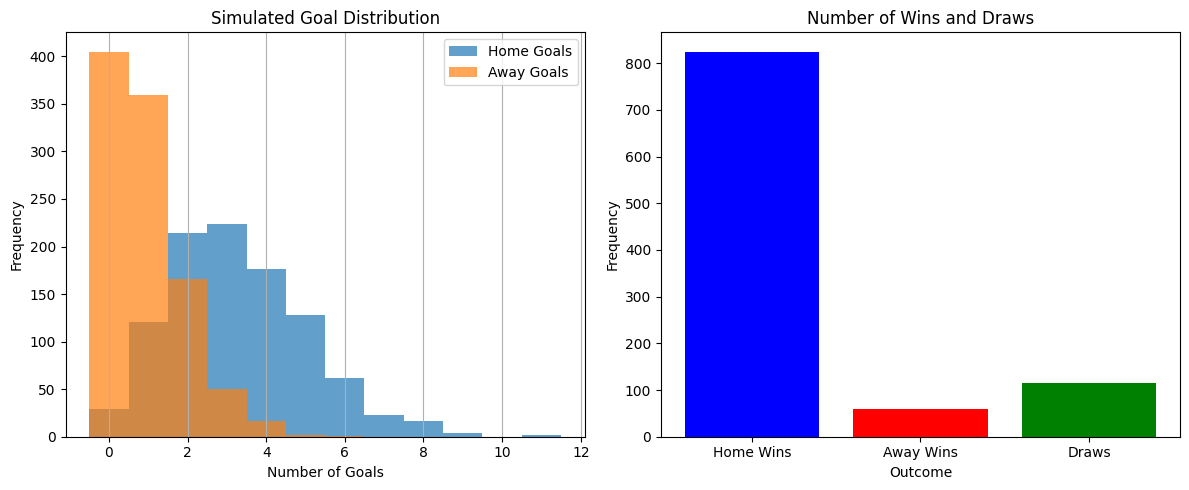

In [14]:
home_goals_simulated = np.random.poisson(home_goal_expectation, num_simulations)
away_goals_simulated = np.random.poisson(away_goal_expectation, num_simulations)

home_wins = np.sum(home_goals_simulated > away_goals_simulated)
away_wins = np.sum(home_goals_simulated < away_goals_simulated)
draws = np.sum(home_goals_simulated == away_goals_simulated)

# Plotting the distributions
plt.figure(figsize=(12, 5))

# Plotting goal distributions
plt.subplot(1, 2, 1)
plt.hist(home_goals_simulated, bins=np.arange(-0.5, max(home_goals_simulated) + 1.5, 1), alpha=0.7, label='Home Goals')
plt.hist(away_goals_simulated, bins=np.arange(-0.5, max(away_goals_simulated) + 1.5, 1), alpha=0.7, label='Away Goals')
plt.xlabel('Number of Goals')
plt.ylabel('Frequency')
plt.title('Simulated Goal Distribution')
plt.legend()
plt.grid(True, axis='x')

# Plotting win counts
plt.subplot(1, 2, 2)
labels = ['Home Wins', 'Away Wins', 'Draws']
values = [home_wins, away_wins, draws]
plt.bar(labels, values, color=['blue', 'red', 'green'])
plt.xlabel('Outcome')
plt.ylabel('Frequency')
plt.title('Number of Wins and Draws')

plt.tight_layout()
plt.show()

## Simulating the championship

In [15]:
sim = df[['HomeTeam', 'AwayTeam']].copy()
sim.head()

,HomeTeam,AwayTeam
0,Crystal Palace,Arsenal
1,Fulham,Liverpool
2,Bournemouth,Aston Villa
3,Leeds,Wolves
4,Newcastle,Nott'm Forest


In [16]:
sim_matches_rs = simulate_season(sim, rs)
sim_standings_rs = calculate_standings(sim_matches_rs)
sim_standings_rs

,Pos,Team,PTS,P,W,D,L,GF,GA,GD,%
0,1,Man City,85,38,26,7,5,105,34,71,74.6
1,2,Newcastle,82,38,25,7,6,75,33,42,71.9
2,3,Liverpool,77,38,23,8,7,73,40,33,67.5
3,4,Arsenal,73,38,22,7,9,93,43,50,64.0
4,5,Man United,70,38,20,10,8,58,36,22,61.4
5,6,Brighton,65,38,20,5,13,68,47,21,57.0
6,7,Aston Villa,61,38,17,10,11,45,43,2,53.5
7,8,Tottenham,61,38,18,7,13,61,63,-2,53.5
8,9,Brentford,60,38,16,12,10,49,41,8,52.6
9,10,Fulham,51,38,13,12,13,53,54,-1,44.7


## Simulating the championship 1000 times

In [17]:
all_standings = []
num_simulations = 100

for i in range(num_simulations):
    matches = simulate_season(sim, rs)
    standings = calculate_standings(matches)
    all_standings.append(standings)

# Now calculate the average standings
average_standings = pd.concat(all_standings).groupby('Team').mean().reset_index()

# Sort the average standings by Points, Goal Difference, and Goals For
average_standings = average_standings.sort_values(by=['PTS', 'GD', 'GF'], ascending=False)

# Add Position (Pos) column
average_standings['Pos'] = average_standings.index + 1
average_standings.set_index('Pos', inplace=True)
average_standings.index.name = 'Pos'
average_standings = average_standings[['Team', 'PTS', 'P', 'W', 'D', 'L', 'GF', 'GA', 'GD', '%']]
average_standings.reset_index(drop=True, inplace=True)

# Display the average standings
average_standings_rs = average_standings
average_standings_rs

,Team,PTS,P,W,D,L,GF,GA,GD,%
0,Man City,87.26,38.0,27.04,6.14,4.82,93.09,32.68,60.41,76.542
1,Arsenal,78.76,38.0,23.96,6.88,7.16,86.70,41.70,45.00,69.086
2,Newcastle,74.33,38.0,21.86,8.75,7.39,66.33,31.89,34.44,65.199
3,Liverpool,64.95,38.0,18.81,8.52,10.67,66.56,46.40,20.16,56.969
4,Man United,62.77,38.0,17.78,9.43,10.79,56.93,40.25,16.68,55.062
5,Brighton,62.48,38.0,18.15,8.03,11.82,70.22,53.77,16.45,54.805
6,Brentford,60.60,38.0,17.26,8.82,11.92,58.06,46.28,11.78,53.151
7,Tottenham,57.43,38.0,16.67,7.42,13.91,68.37,62.80,5.57,50.373
8,Aston Villa,55.60,38.0,15.23,9.91,12.86,50.45,45.67,4.78,48.774
9,Fulham,55.36,38.0,15.44,9.04,13.52,55.67,52.17,3.50,48.562


In [30]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarities = []

# Loop through each DataFrame in all_standings_dc
for idx, df in enumerate(all_standings_dc):
    # Calculate cosine similarity with average_standings_dc['PTS']
    cosine_sim = cosine_similarity(df['PTS'].values.reshape(1, -1), average_standings_dc['PTS'].values.reshape(1, -1))
    
    # Append the index and cosine similarity value to the list
    cosine_similarities.append({'index': idx, 'cosine_similarity': cosine_sim[0][0]})

# Create a DataFrame from the list of dictionaries
cosine = pd.DataFrame(cosine_similarities)

# Display the resulting DataFrame
all_standings_dc[19]

,Pos,Team,PTS,P,W,D,L,GF,GA,GD,%
0,1,Man City,95,38,30,5,3,100,28,72,83.3
1,2,Arsenal,92,38,29,5,4,88,37,51,80.7
2,3,Newcastle,80,38,23,11,4,86,35,51,70.2
3,4,Man United,73,38,22,7,9,57,43,14,64.0
4,5,Liverpool,71,38,21,8,9,84,48,36,62.3
5,6,Aston Villa,68,38,21,5,12,58,42,16,59.6
6,7,Brighton,65,38,19,8,11,81,58,23,57.0
7,8,Tottenham,62,38,18,8,12,74,60,14,54.4
8,9,Fulham,58,38,18,4,16,62,51,11,50.9
9,10,Brentford,50,38,13,11,14,50,49,1,43.9


## Real standings

In [18]:
real = df.copy()
real.drop(columns=['Date'], inplace=True)
real.rename(columns={'FTHG': 'HG', 'FTAG': 'AG'}, inplace=True)

real_standings = calculate_standings(real)
real_standings

,Pos,Team,PTS,P,W,D,L,GF,GA,GD,%
0,1,Man City,89,38,28,5,5,94,33,61,78.1
1,2,Arsenal,84,38,26,6,6,88,43,45,73.7
2,3,Man United,75,38,23,6,9,58,43,15,65.8
3,4,Newcastle,71,38,19,14,5,68,33,35,62.3
4,5,Liverpool,67,38,19,10,9,75,47,28,58.8
5,6,Brighton,62,38,18,8,12,72,53,19,54.4
6,7,Aston Villa,61,38,18,7,13,51,46,5,53.5
7,8,Tottenham,60,38,18,6,14,70,63,7,52.6
8,9,Brentford,59,38,15,14,9,58,46,12,51.8
9,10,Fulham,52,38,15,7,16,55,53,2,45.6


## Comparing Real and Sim standings

In [19]:
# Merge real_standings and sim_standings on 'Team' to compare attributes
comparison = pd.merge(real_standings, average_standings_rs, on='Team', suffixes=('_real', '_sim'))

# Calculate absolute differences for each attribute
attributes = ['PTS', 'W', 'D', 'L', 'GF', 'GA', 'GD', '%']
for attr in attributes:
    comparison[f'{attr}_diff'] = abs(comparison[f'{attr}_sim'] - comparison[f'{attr}_real'])

# Reorder columns for better readability (if needed)
comparison = comparison[['Team'] + [f'{attr}_real' for attr in attributes] + [f'{attr}_sim' for attr in attributes] + [f'{attr}_diff' for attr in attributes]]

diff_columns = [col for col in comparison.columns if col.endswith('_diff')]
diff_columns.append('Team')
comparison = comparison[diff_columns]
columns_order = ['Team'] + [col for col in comparison.columns if col != 'Team']
comparison = comparison[columns_order]
comparison.columns = comparison.columns.str.replace('_diff', '')

comparison_rs = comparison
comparison_rs

,Team,PTS,W,D,L,GF,GA,GD,%
0,Man City,1.74,0.96,1.14,0.18,0.91,0.32,0.59,1.558
1,Arsenal,5.24,2.04,0.88,1.16,1.30,1.30,0.00,4.614
2,Man United,12.23,5.22,3.43,1.79,1.07,2.75,1.68,10.738
3,Newcastle,3.33,2.86,5.25,2.39,1.67,1.11,0.56,2.899
4,Liverpool,2.05,0.19,1.48,1.67,8.44,0.60,7.84,1.831
5,Brighton,0.48,0.15,0.03,0.18,1.78,0.77,2.55,0.405
6,Aston Villa,5.40,2.77,2.91,0.14,0.55,0.33,0.22,4.726
7,Tottenham,2.57,1.33,1.42,0.09,1.63,0.20,1.43,2.227
8,Brentford,1.60,2.26,5.18,2.92,0.06,0.28,0.22,1.351
9,Fulham,3.36,0.44,2.04,2.48,0.67,0.83,1.50,2.962


# Final comparison

## Real standings

In [20]:
real_standings

,Pos,Team,PTS,P,W,D,L,GF,GA,GD,%
0,1,Man City,89,38,28,5,5,94,33,61,78.1
1,2,Arsenal,84,38,26,6,6,88,43,45,73.7
2,3,Man United,75,38,23,6,9,58,43,15,65.8
3,4,Newcastle,71,38,19,14,5,68,33,35,62.3
4,5,Liverpool,67,38,19,10,9,75,47,28,58.8
5,6,Brighton,62,38,18,8,12,72,53,19,54.4
6,7,Aston Villa,61,38,18,7,13,51,46,5,53.5
7,8,Tottenham,60,38,18,6,14,70,63,7,52.6
8,9,Brentford,59,38,15,14,9,58,46,12,51.8
9,10,Fulham,52,38,15,7,16,55,53,2,45.6


## Dixon Coles table

In [21]:
comparison_dc

,Team,PTS,W,D,L,GF,GA,GD,%
0,Man City,2.61,1.30,1.29,0.01,1.49,0.73,0.76,2.316
1,Arsenal,5.82,2.31,1.11,1.20,0.43,0.09,0.34,5.116
2,Man United,12.42,5.16,3.06,2.10,0.37,1.02,0.65,10.905
3,Newcastle,4.62,3.48,5.82,2.34,0.26,0.85,1.11,4.037
4,Liverpool,1.33,1.17,2.18,1.01,1.73,0.74,2.47,1.136
5,Brighton,1.84,0.65,0.11,0.54,0.27,1.17,1.44,1.602
6,Aston Villa,5.07,2.40,2.13,0.27,0.20,0.03,0.17,4.440
7,Tottenham,1.29,0.95,1.56,0.61,0.44,0.18,0.62,1.096
8,Brentford,1.09,1.99,4.88,2.89,0.74,0.36,1.10,0.914
9,Fulham,3.79,0.67,1.78,2.45,2.03,0.62,2.65,3.341


## Rue Salvesen table

In [22]:
comparison_rs

,Team,PTS,W,D,L,GF,GA,GD,%
0,Man City,1.74,0.96,1.14,0.18,0.91,0.32,0.59,1.558
1,Arsenal,5.24,2.04,0.88,1.16,1.30,1.30,0.00,4.614
2,Man United,12.23,5.22,3.43,1.79,1.07,2.75,1.68,10.738
3,Newcastle,3.33,2.86,5.25,2.39,1.67,1.11,0.56,2.899
4,Liverpool,2.05,0.19,1.48,1.67,8.44,0.60,7.84,1.831
5,Brighton,0.48,0.15,0.03,0.18,1.78,0.77,2.55,0.405
6,Aston Villa,5.40,2.77,2.91,0.14,0.55,0.33,0.22,4.726
7,Tottenham,2.57,1.33,1.42,0.09,1.63,0.20,1.43,2.227
8,Brentford,1.60,2.26,5.18,2.92,0.06,0.28,0.22,1.351
9,Fulham,3.36,0.44,2.04,2.48,0.67,0.83,1.50,2.962


## Points predictions

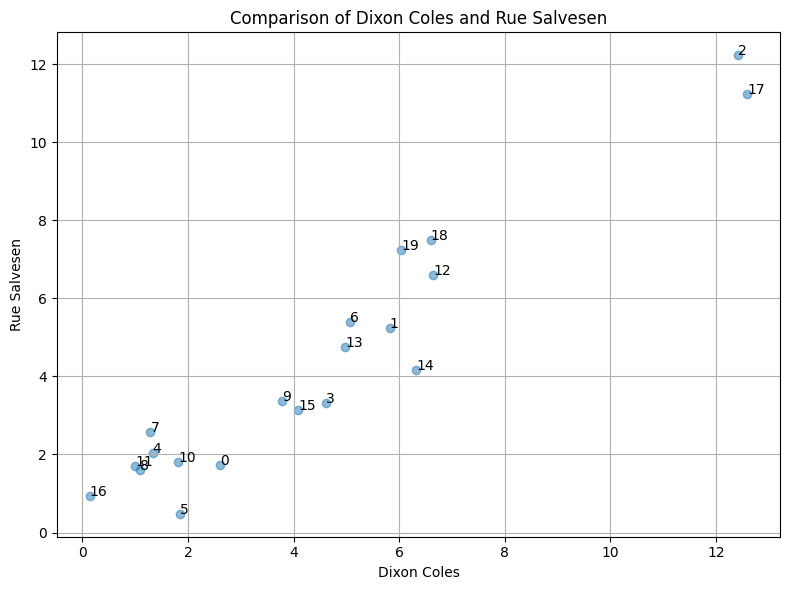

In [23]:
plt.figure(figsize=(8, 6))

plt.scatter(comparison_dc['PTS'], comparison_rs['PTS'], alpha=0.5)
plt.xlabel('Dixon Coles')
plt.ylabel('Rue Salvesen')
plt.title('Comparison of Dixon Coles and Rue Salvesen')
plt.grid(True)

# Annotate each point with the team name
for i, team in enumerate(comparison_dc.index):
    plt.text(comparison_dc['PTS'][i], comparison_rs['PTS'][i], team)

plt.tight_layout()
plt.show()

## Goals predictions

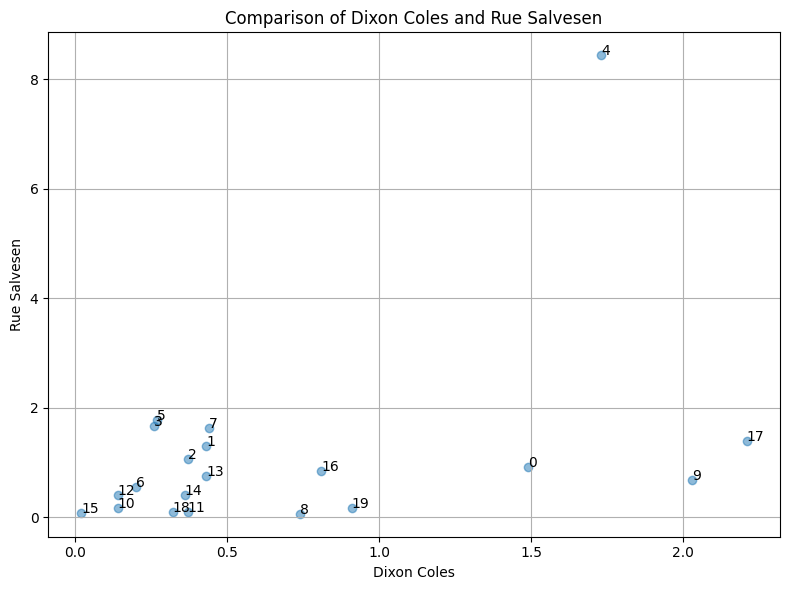

In [24]:
plt.figure(figsize=(8, 6))

plt.scatter(comparison_dc['GF'], comparison_rs['GF'], alpha=0.5)
plt.xlabel('Dixon Coles')
plt.ylabel('Rue Salvesen')
plt.title('Comparison of Dixon Coles and Rue Salvesen')
plt.grid(True)

# Annotate each point with the team name
for i, team in enumerate(comparison_dc.index):
    plt.text(comparison_dc['GF'][i], comparison_rs['GF'][i], team)

plt.tight_layout()
plt.show()